In [1]:
%load_ext autoreload
%autoreload 2

import torch    
from Classifier_NN import Classifier_MNIST
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from NObSP_Decomposition import NObSP_NN_single_MultiOutput, NObSP_NN_single_MultiOutput_reg
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader as tf_dataloader
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns

In [2]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(2, 2))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

In [3]:
# Cargar los tensores guardados
images = torch.load('train_images_mnist.pth')
test = torch.load('test_images_mnist.pth')
X = torch.load('train_tensors_mnist.pth')
y = torch.load('train_labels_mnist.pth')

X = torch.cat(X).detach()
y = F.one_hot(torch.cat(y))

labels = tuple(str(i) for i in range(10))

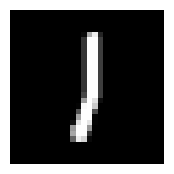

In [4]:
imshow(torchvision.utils.make_grid(images[1000]))

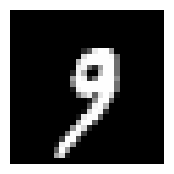

In [5]:
imshow(torchvision.utils.make_grid(test[1000]))

In [6]:
X_sample = []
y_sample = []
index_used = []

sample_size = 500
# Supongamos que 'num_classes' es el número de clases en tus etiquetas
for i in range(10):
    indices = torch.where(y.argmax(dim=1) == i)[0]
    indices = indices[torch.randperm(len(indices))[:sample_size]]
    index_used.append(indices)
    X_sample.append(X[indices])
    y_sample.append(y[indices])

# Verifica que cada tensor en X_sample y y_sample es diferente
for i in range(len(X_sample)):
    for j in range(i + 1, len(X_sample)):
        assert id(X_sample[i]) != id(X_sample[j])
        assert id(y_sample[i]) != id(y_sample[j])

index_used = [tensor.item() for sublist in index_used for tensor in sublist]
images_sample = [images[i] for i in index_used]
X_sample = torch.cat(X_sample)
y_sample = torch.cat(y_sample)

In [7]:
X_sample.shape

torch.Size([5000, 968])

In [8]:
N = np.size(X_sample, 0); # Defining the number of datapoints
in_feat = np.size(X_sample, 1)

In [9]:
t = np.arange(0, N)
train_split = int(0.8 * N)
p = 10

In [10]:
epochs = 1500
learning_rate = 0.001

In [11]:
# Split of the data for training and test
X_train, X_test, y_train, y_test = train_test_split(
    X_sample,
    y_sample,
    train_size = train_split,
    random_state=42
) 

## Creating model for single nonlinear effects

classifier = Classifier_MNIST(in_number=X_sample.shape[1], out_number=y_sample.shape[1]) # Creating the model
loss_fcn = nn.CrossEntropyLoss() # Definning loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

# Training loop for the model 1

In [12]:
for epoch in range(epochs):
    classifier.train() # Setting the model in training mode
    y_prob, x_p, y_lin = classifier(X_train) #forward pass
    
    loss = loss_fcn(y_prob,
                    y_train.float())  # Compute Loss
    loss.backward() # compute backward
    optimizer.step() # update parameters
    optimizer.zero_grad() #zero grad optimizer
    
    ## Testing
    classifier.eval() # Setting the model in evalaution mode
    with torch.inference_mode():
        y_prob_pred, x_trans, y_lin_pred = classifier(X_test) # Estimating th emodel output in test data
    
    test_loss = loss_fcn(y_prob_pred,
                         y_test.float()) # Evaluating loss
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | test Loss: {test_loss:.5f}') # Printing the performance of the model as it is trained

Epoch: 0 | Loss: 2.30277 | test Loss: 2.29338
Epoch: 10 | Loss: 1.66397 | test Loss: 1.64038
Epoch: 20 | Loss: 1.53513 | test Loss: 1.54837
Epoch: 30 | Loss: 1.49973 | test Loss: 1.52124
Epoch: 40 | Loss: 1.48466 | test Loss: 1.51531
Epoch: 50 | Loss: 1.47955 | test Loss: 1.51509
Epoch: 60 | Loss: 1.47654 | test Loss: 1.51275
Epoch: 70 | Loss: 1.47509 | test Loss: 1.51358
Epoch: 80 | Loss: 1.47425 | test Loss: 1.51276
Epoch: 90 | Loss: 1.47414 | test Loss: 1.51060
Epoch: 100 | Loss: 1.47399 | test Loss: 1.51116
Epoch: 110 | Loss: 1.47385 | test Loss: 1.50993
Epoch: 120 | Loss: 1.47382 | test Loss: 1.50965
Epoch: 130 | Loss: 1.47335 | test Loss: 1.50875
Epoch: 140 | Loss: 1.47303 | test Loss: 1.50753
Epoch: 150 | Loss: 1.47285 | test Loss: 1.50966
Epoch: 160 | Loss: 1.47282 | test Loss: 1.50919
Epoch: 170 | Loss: 1.47281 | test Loss: 1.50900
Epoch: 180 | Loss: 1.47280 | test Loss: 1.50861
Epoch: 190 | Loss: 1.47279 | test Loss: 1.50876
Epoch: 200 | Loss: 1.47278 | test Loss: 1.50845
Epo

In [13]:
correct = 0
total = 0

classifier.eval()
with torch.inference_mode():
    outputs, _, _ = classifier(X_test)
    for tensor, label in zip(outputs, y_test):
        predicted = torch.argmax(tensor)
        label = torch.argmax(label) 
        total += 1
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.3f} %')

Test Accuracy: 95.900 %


In [14]:
classifier.eval()  # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_1, x_trans_total_1, y_est_1 = classifier(
        X_sample
    )  # Computing the nonlinear transformation of the input data X

In [15]:
betas_tensor = NObSP_NN_single_MultiOutput_reg(
    X_sample, y_prob_1, classifier
)  # Computing the decomposition using NObSP. The Alpha parameters are the weigths for the Interpretation Layer

betas_tensor = betas_tensor.cpu()

In [16]:
betas_tensor.shape

torch.Size([128, 968, 10])

In [17]:
def get_contrib(X, model, betas): # revisar como se puede hacer cam, pintar la contribucion de cada variable
    X_new = X.clone()
    clase = int(np.argmax(model(X_new.unsqueeze(0))[0].detach(), axis=1))
    X_target_tot = torch.zeros((1, list(model.children())[-1].in_features))

    for i in range(len(X_new)):
        X_temp = np.zeros((1, len(X_new)))
        X_temp[:,i] = X_new[i]
        X_temp = torch.from_numpy(X_temp).type(torch.float)
        with torch.inference_mode():
            _, X_latent, _ = model(X_new.unsqueeze(0))
            _, X_target, _ = model(X_temp)
        X_target_tot = torch.cat((X_target_tot, X_target), 0)
    X_target_tot = X_target_tot[1:]

    contrib = (X_target_tot@betas[:, :, clase]).diag()
    return clase, contrib, X_latent

In [18]:
def train_contribs(X, model, betas):
    contribs = []
    labels = []
    tensors = []
    latents = []
    for i in range(len(X)):
        label, contrib, latent = get_contrib(X[i], model, betas)
        contribs.append(contrib.numpy())
        labels.append(label)
        tensors.append(X[i].numpy())
        latents.append(latent.numpy()[0])

    train_contribs = pd.DataFrame(
        {
            'Contrib': contribs,
            'Label': labels,
            'Flatten': tensors,
            'Latent': latents
        }
    )
    return train_contribs

In [19]:
train_contribs = train_contribs(X_sample, classifier, betas_tensor)
train_contribs.head()

,Contrib,Label,Flatten,Latent
0,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 19.354858, 0.0, 4.2641783, 32.915737, 0...."
1,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 18.340246, 0.0, 0.0, 32.874077, 0.0, 19...."
2,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 10.019825, 0.0, 0.0, 2.9324543, 0.0, 6.2..."
3,"[18.788004, -0.5488584, 0.08289203, 0.00667489...",0,"[0.22523598, 0.22523598, 0.22523598, 0.0, 0.0,...","[0.0, 15.623276, 0.0, 0.0, 24.786379, 0.0, 27...."
4,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 30.610964, 0.0, 0.0, 32.92417, 0.0, 24.7..."


In [20]:
def viz_contrib(train_contribs):
    
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=20,
    )
    tsne_contrib = tsne.fit_transform(train_contribs['Contrib'].apply(pd.Series))
    tsne_contrib = pd.DataFrame(tsne_contrib, columns=['tsne_1', 'tsne_2'])
    
    tsne_flatten = tsne.fit_transform(train_contribs['Flatten'].apply(pd.Series))
    tsne_flatten = pd.DataFrame(tsne_flatten, columns=['tsne_1', 'tsne_2'])
    
    tsne_latent = tsne.fit_transform(train_contribs['Latent'].apply(pd.Series))
    tsne_latent = pd.DataFrame(tsne_latent, columns=['tsne_1', 'tsne_2'])
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))
    sns.scatterplot(
        data=tsne_contrib,
        x='tsne_1', y='tsne_2',
        hue=train_contribs['Label'],
        palette='Paired',
        ax=ax[0]
    )
    ax[0].set_title('Contributions')
    ax[0].grid(alpha=0.4)
    
    sns.scatterplot(
        data=tsne_flatten,
        x='tsne_1', y='tsne_2',
        hue=train_contribs['Label'],
        palette='Paired',
        ax=ax[1]
    )
    ax[1].set_title('Flatten')
    ax[1].grid(alpha=0.4)
    
    sns.scatterplot(
        data=tsne_latent,
        x='tsne_1', y='tsne_2',
        hue=train_contribs['Label'],
        palette='Paired',
        ax=ax[2]
    )
    ax[2].set_title('Latent')
    ax[2].grid(alpha=0.4)
    
    plt.show()

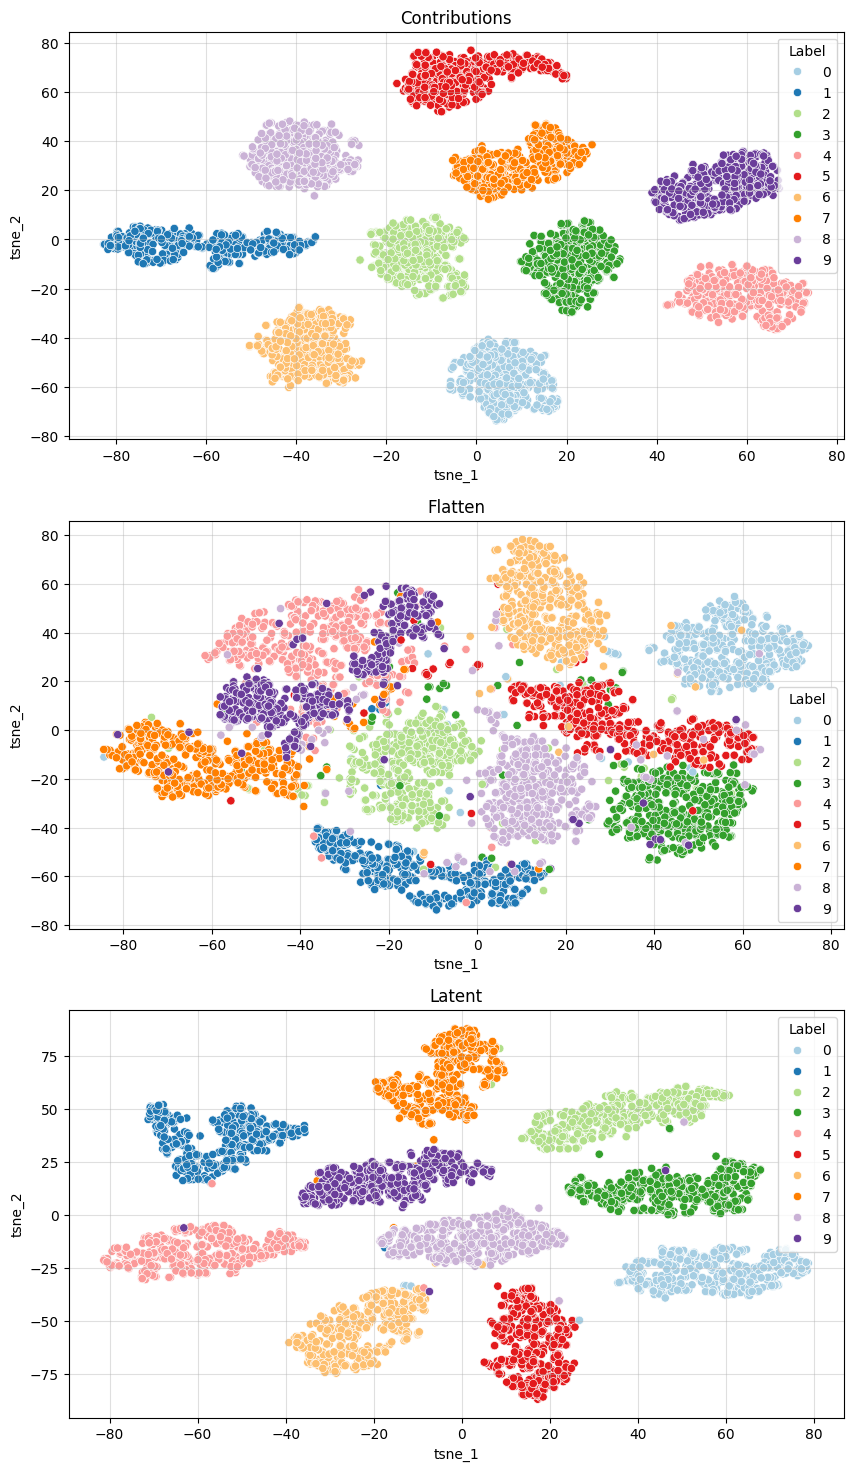

In [21]:
viz_contrib(train_contribs)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=0)
        
        self.layer2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=0)
        
        self.layer3 = nn.Flatten()
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(in_features=968, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        
        self.x1 = F.relu(self.layer1(x))
        self.x2 = F.relu(self.layer2(self.x1))
        
        self.x3 = self.layer3(self.x2)
        self.x4 = self.drop1(self.x3)
        
        self.x5 = F.relu(self.fc1(self.x4))
        self.x6 = F.softmax(self.fc2(self.x5), dim = 1)
            
        return self.x3, self.x6

net = Net()
net.load_state_dict(torch.load('best_model_mnist.pth'))

<All keys matched successfully>

In [23]:
train_contribs.columns

Index(['Contrib', 'Label', 'Flatten', 'Latent'], dtype='object')

In [24]:
def top5_cosine(data, y, index, net, df): #incluir label original, label del modelo
    with torch.inference_mode():
        flatten, net_label = net(data[index])
        _, contrib, latent = get_contrib(flatten[0], classifier, betas_tensor)
    net_label = torch.argmax(net_label)
    
    # Convertir cada array en la columna del DataFrame en un tensor
    contrib_list = [torch.tensor(x) for x in df['Contrib']]
    flatten_list = [torch.tensor(x) for x in df['Flatten']]
    latent_list = [torch.tensor(x) for x in df['Latent']]
    

    # Calcular la similitud del coseno para las contribuciones
    similarities_contrib = [F.cosine_similarity(contrib, tensor, dim=0) for tensor in contrib_list]
    similarities_contrib = torch.tensor(similarities_contrib)
    
    # Calcular la similitud del coseno para los flatten
    similarities_flatten = [F.cosine_similarity(flatten[0], tensor, dim=0) for tensor in flatten_list]
    similarities_flatten = torch.tensor(similarities_flatten)
    
   # Calcular la similitud del coseno para los flatten
    similarities_latent = [F.cosine_similarity(latent[0], tensor, dim=0) for tensor in latent_list]
    similarities_latent = torch.tensor(similarities_latent) 

    # Encontrar los top 5
    top5_indices_contrib = torch.topk(similarities_contrib, 5).indices
    top5_indices_flatten = torch.topk(similarities_flatten, 5).indices
    top5_indices_latent = torch.topk(similarities_latent, 5).indices

    # Visualizar la imagen original
    fig, axs = plt.subplots(4, 5, figsize=(15, 10))
    img = torchvision.utils.make_grid(data[index]) / 2 + 0.5
    npimg = img.numpy()
    axs[0, 2].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[0, 2].set_title(f"Real Label: {torch.argmax(y[index])}\n Model Label: {net_label}")

    # Desactivar los espacios vacíos en la primera fila
    for i in [0, 1, 3, 4]:
        axs[0, i].axis("off")

    # Visualizar las imágenes más similares para los tensores
    for i, idx in enumerate(top5_indices_contrib):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        axs[1, i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[1, i].set_title(f"Contrib {i+1} - Sim: {similarities_contrib[idx]:.3f}\n Real Label: {torch.argmax(y_sample[idx])}")

    # Visualizar las imágenes más similares para los flatten
    for i, idx in enumerate(top5_indices_flatten):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        axs[2, i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[2, i].set_title(f"Flatten {i+1} - Sim: {similarities_flatten[idx]:.3f}\n Real Label: {torch.argmax(y_sample[idx])}")

    # Visualizar las imágenes más similares para los flatten
    for i, idx in enumerate(top5_indices_latent):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        axs[3, i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[3, i].set_title(f"Latent {i+1} - Sim: {similarities_latent[idx]:.3f}\n Real Label: {torch.argmax(y_sample[idx])}")
    
    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
def procesar_lista(lista, top_n, positivo=True):
    if positivo:
        elementos = [(i, num) for i, num in enumerate(lista) if num > 0]
    else:
        elementos = [(i, num) for i, num in enumerate(lista) if num < 0]
    total_elementos = sum(num for _, num in elementos)
    porcentajes = [(i, num, num / total_elementos * 100) for i, num in elementos]
    porcentajes_ordenados = sorted(porcentajes, key=lambda x: x[2], reverse=positivo)
    return porcentajes_ordenados[:top_n]

def graficar_elementos(ax, resultado, top_n, positivo=True):
    indices = [tupla[0] for tupla in resultado]
    entradas = [tupla[1] for tupla in resultado]
    porcentajes = [tupla[2] for tupla in resultado]

    color = 'tab:blue' if positivo else 'tab:red'
    ax.barh(range(len(indices)), porcentajes, color = color)

    etiquetas_y = [f"Entrada: {i}, Valor: {e:.3f}" for i, e in zip(indices, entradas)]
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(etiquetas_y)

    ax.invert_yaxis()

    ax.set_xlabel('Porcentaje (%)')
    if positivo:
        ax.set_title(f'Top {top_n} Entradas Positivas por Porcentaje')
    else:
        ax.set_title(f'Top {top_n} Entradas Negativas por Porcentaje')

def graficar_entradas(tensor, top_n=15):
    lista = tensor.tolist()
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    resultado_positivos = procesar_lista(lista, top_n, positivo=True)
    graficar_elementos(axs[0], resultado_positivos, top_n, positivo=True)

    resultado_negativos = procesar_lista(lista, top_n, positivo=False)
    graficar_elementos(axs[1], resultado_negativos, top_n, positivo=False)

    plt.tight_layout()
    plt.show()

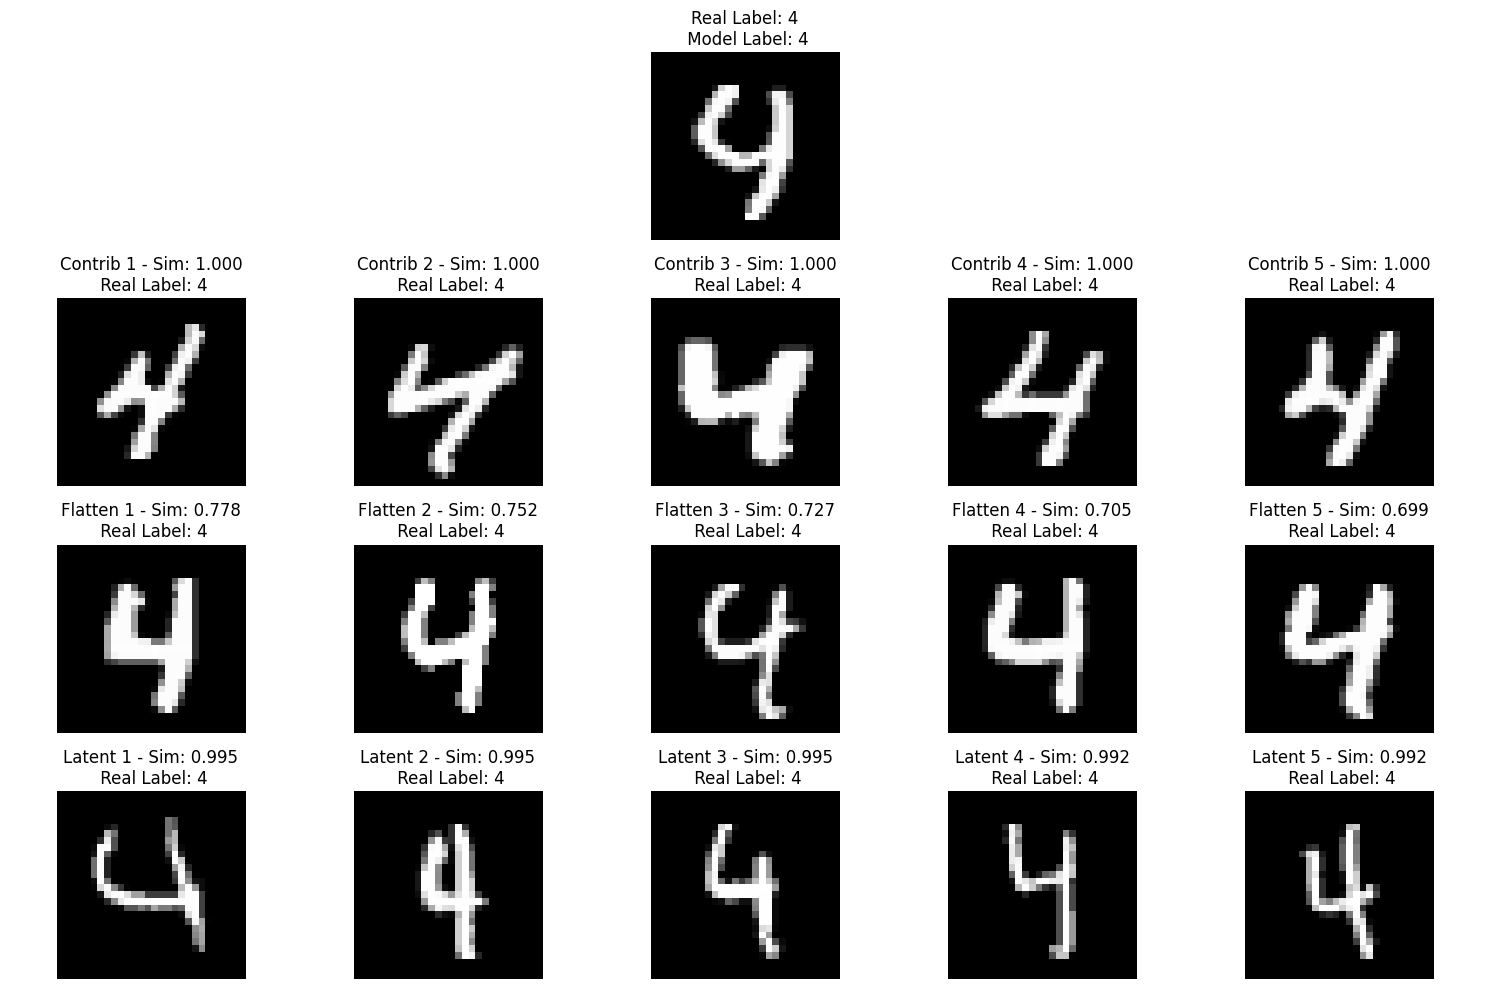

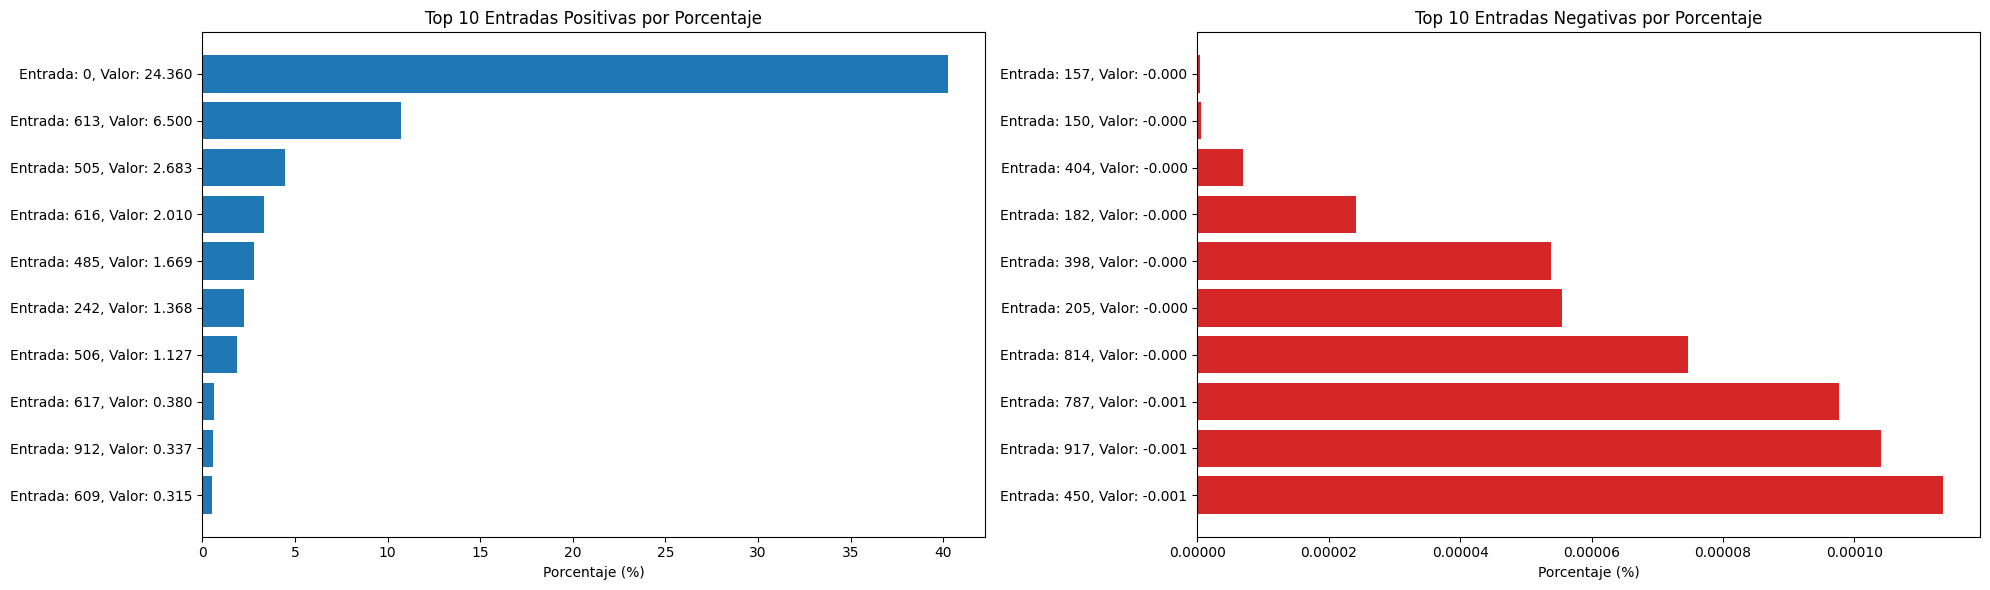

In [38]:
index = 544 #quitar el valor, dejar porcentaje
with torch.inference_mode():
    flatten, _ = net(images[index])
_, contrib, _ = get_contrib(flatten[0], classifier, betas_tensor)

top5_cosine(images, y, index, net, train_contribs)
graficar_entradas(contrib, top_n=10)

In [27]:
# Inicializa una lista para almacenar las probabilidades junto con sus índices
probabilities_with_indices = []

# Pasa cada imagen a través de la red
for i, image in enumerate(images):

    # Pasa la imagen a través del modelo
    with torch.no_grad():
        _, output = net(image)  # Añade una dimensión extra para el batch

    # Obtén la probabilidad de la clase más probable
    _, predicted_class = torch.max(output, dim=1)
    max_probability = output[0, predicted_class]

    # Añade las probabilidades a la lista junto con su índice
    probabilities_with_indices.append((max_probability.item(), i))

# Ordena la lista de tuplas por la probabilidad
probabilities_with_indices.sort()

# Obtén los índices de las 10 imágenes con las menores probabilidades
lowest_indices = [index for _, index in probabilities_with_indices[:20]]

print(lowest_indices)

[22862, 4598, 51333, 39922, 55892, 42600, 19310, 2742, 16044, 6527, 52527, 41605, 33090, 5633, 16634, 35698, 6157, 13451, 46350, 553]


In [28]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

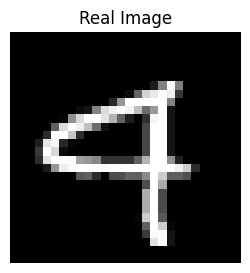

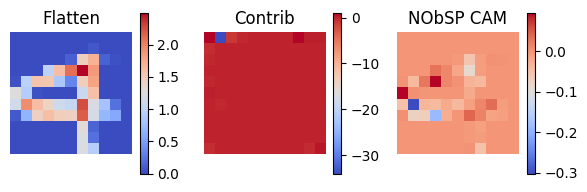

In [36]:
index = 4598
with torch.inference_mode():
    flatten, _ = net(images[index])
    _, contrib, _ = get_contrib(flatten[0], classifier, betas_tensor)

nobs_cam = flatten*contrib
nobs_cam = nobs_cam.view(net.x2.shape)
nobs_cam = torch.mean(nobs_cam, dim=1)
#nobs_cam = (nobs_cam - nobs_cam.min()) / (nobs_cam.max() - nobs_cam.min())

contrib = contrib.view(net.x2.shape)
contrib = torch.mean(contrib, dim=1)
#contrib = (contrib - contrib.min()) / (contrib.max() - contrib.min())

flatten = flatten.view(net.x2.shape)
flatten = torch.mean(flatten, dim=1)
#flatten = (flatten - flatten.min()) / (flatten.max() - flatten.min())

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(images[index].squeeze(), cmap='gray')
ax.axis('off')
ax.set_title("Real Image")
plt.show()

cmap = 'coolwarm'
fig, ax = plt.subplots(1, 3, figsize=(6, 2))  # Aumentamos el ancho de la figura
ax[0].imshow(flatten.squeeze(), cmap=cmap)
ax[0].set_title("Flatten")
cbar0 = plt.colorbar(ax[0].imshow(flatten.squeeze(), cmap=cmap), ax=ax[0])

ax[1].imshow(contrib.squeeze(), cmap=cmap)
ax[1].set_title("Contrib")
cbar1 = plt.colorbar(ax[1].imshow(contrib.squeeze(), cmap=cmap), ax=ax[1])

ax[2].imshow(nobs_cam.squeeze(), cmap=cmap)
ax[2].set_title("NObSP CAM")
cbar2 = plt.colorbar(ax[2].imshow(nobs_cam.squeeze(), cmap=cmap), ax=ax[2])

for ax in ax.flat:
    ax.axis('off')

plt.tight_layout()  # Ajusta el espaciado entre las subtramas
plt.show()

In [30]:
train_contribs

,Contrib,Label,Flatten,Latent
0,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 19.354858, 0.0, 4.2641783, 32.915737, 0...."
1,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 18.340246, 0.0, 0.0, 32.874077, 0.0, 19...."
2,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 10.019825, 0.0, 0.0, 2.9324543, 0.0, 6.2..."
3,"[18.788004, -0.5488584, 0.08289203, 0.00667489...",0,"[0.22523598, 0.22523598, 0.22523598, 0.0, 0.0,...","[0.0, 15.623276, 0.0, 0.0, 24.786379, 0.0, 27...."
4,"[18.771868, -0.5955726, 0.04886247, 0.00667489...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 30.610964, 0.0, 0.0, 32.92417, 0.0, 24.7..."
...,...,...,...,...
4995,"[0.47721654, -0.04118243, 0.0036168357, 0.0902...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 25.362865, 0.0, 14.555707, 17.68753, 0.0..."
4996,"[-75.137215, -0.17661875, -0.09017974, -0.0470...",8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 16.456741, 0.0, 5.9122667, 16.582312, 0...."
4997,"[0.47721654, -0.04118243, 0.0036168357, 0.0902...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 17.07177, 0.0, 6.4553165, 8.086468, 0.0,..."
4998,"[0.47721654, -0.04118243, 0.0036168357, 0.0902...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 7.800956, 0.0, 11.966735, 4.022441, 0.0,..."


<Axes: >

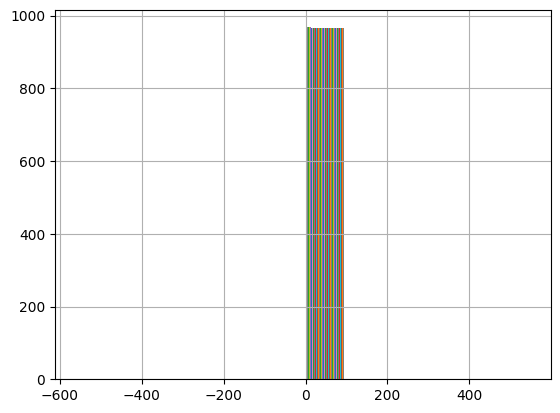

In [31]:
train_contribs['Contrib'].hist()

In [32]:
# el punto a punto es entre el flatten y el contrib

# el reshape debe ser por los tamaños del tensor

# Promedio por la dimension de los kernels

# jugar con el tensor de contribuciones considerando las positivas y no las negativas y eso

# probar si el cero afecta
# probar si el flatten sirve
# probar solo con el contrib

In [33]:
# considerar betas positivos